In [1]:
import pandas as pd

df = pd.read_csv(r'C:\Users\clint\Desktop\Booth RA\RA_21_22.csv')
df

,weight,year,age,sex,education,race,asset_total,asset_housing,debt_total,debt_housing,income
0,6859.959728,1989,35,female,no college,white,3731.72,0.00,1530.01,0.00,9737.17
1,7375.788638,1989,35,female,no college,black,0.00,0.00,0.00,0.00,11684.60
2,4193.294199,1989,40,male,no college,other,216439.77,139939.51,26681.80,18658.60,83739.63
3,4743.208024,1989,51,female,no college,black,40060.02,18658.60,26383.26,5597.58,19474.33
4,5971.319496,1989,28,male,no college,black,35675.24,33585.48,27987.90,20524.46,35053.80
...,...,...,...,...,...,...,...,...,...,...,...
47771,3033.103970,2016,43,male,some college,white,253300.00,0.00,96500.00,0.00,113415.28
47772,5721.988043,2016,67,male,some college,white,279400.00,120000.00,15000.00,0.00,109364.73
47773,4824.390087,2016,60,male,college degree,white,1500.00,0.00,35000.00,0.00,40505.46
47774,4132.549093,2016,48,female,no college,white,4430.00,0.00,100.00,0.00,23290.64


In [2]:
# COMPREHENSIVE DATA QUALITY ASSESSMENT
print("=== DATA QUALITY ASSESSMENT ===\n")

# 1. Basic dataset information
print("1. DATASET OVERVIEW:")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Columns: {list(df.columns)}")

# 2. Missing values analysis
print("\n2. MISSING VALUES CHECK:")
missing_summary = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])
if missing_df['Missing_Count'].sum() == 0:
    print("   ✓ No missing values found")

# 3. Data types and value ranges
print("\n3. DATA TYPES AND RANGES:")
for col in df.columns:
    dtype = df[col].dtype
    if df[col].dtype in ['int64', 'float64']:
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"   {col}: {dtype} | Range: {min_val:,.2f} to {max_val:,.2f}")
    else:
        unique_count = df[col].nunique()
        print(f"   {col}: {dtype} | {unique_count} unique values")

# 4. Check for negative values in financial columns
print("\n4. NEGATIVE VALUES CHECK:")
financial_cols = ['weight', 'asset_total', 'asset_housing', 'debt_total', 'debt_housing', 'income', 'wealth']
for col in financial_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        negative_pct = (negative_count / len(df)) * 100
        if negative_count > 0:
            print(f"   ⚠️ {col}: {negative_count:,} negative values ({negative_pct:.2f}%)")
        else:
            print(f"   ✓ {col}: No negative values")

# 5. Outlier detection using IQR method
print("\n5. OUTLIER DETECTION (IQR Method):")
for col in financial_cols:
    if col in df.columns and df[col].dtype in ['int64', 'float64']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_pct = (outliers / len(df)) * 100
        print(f"   {col}: {outliers:,} outliers ({outlier_pct:.1f}%) | Bounds: [{lower_bound:,.0f}, {upper_bound:,.0f}]")

# 6. Categorical variables validation
print("\n6. CATEGORICAL VARIABLES:")
categorical_cols = ['race', 'education', 'sex']
for col in categorical_cols:
    if col in df.columns:
        value_counts = df[col].value_counts()
        print(f"   {col}:")
        for value, count in value_counts.items():
            pct = (count / len(df)) * 100
            print(f"     - {value}: {count:,} ({pct:.1f}%)")

# 7. Year distribution
print("\n7. YEAR DISTRIBUTION:")
if 'year' in df.columns:
    year_counts = df['year'].value_counts().sort_index()
    for year, count in year_counts.items():
        pct = (count / len(df)) * 100
        print(f"   {year}: {count:,} observations ({pct:.1f}%)")

# 8. Logical consistency checks
print("\n8. LOGICAL CONSISTENCY CHECKS:")

# Check if housing assets <= total assets
if 'asset_housing' in df.columns and 'asset_total' in df.columns:
    housing_gt_total = (df['asset_housing'] > df['asset_total']).sum()
    if housing_gt_total > 0:
        print(f"   ⚠️ {housing_gt_total:,} cases where housing assets > total assets")
    else:
        print("   ✓ Housing assets ≤ total assets for all cases")

# Check if housing debt <= total debt
if 'debt_housing' in df.columns and 'debt_total' in df.columns:
    housing_debt_gt_total = (df['debt_housing'] > df['debt_total']).sum()
    if housing_debt_gt_total > 0:
        print(f"   ⚠️ {housing_debt_gt_total:,} cases where housing debt > total debt")
    else:
        print("   ✓ Housing debt ≤ total debt for all cases")

# Check if wealth calculation is consistent
if 'wealth' in df.columns:
    calculated_wealth = df['asset_total'] + df['asset_housing'] - df['debt_total'] - df['debt_housing']
    wealth_inconsistent = (abs(df['wealth'] - calculated_wealth) > 0.01).sum()
    if wealth_inconsistent > 0:
        print(f"   ⚠️ {wealth_inconsistent:,} cases with inconsistent wealth calculation")
    else:
        print("   ✓ Wealth calculation is consistent")

# 9. Survey weights validation
print("\n9. SURVEY WEIGHTS VALIDATION:")
if 'weight' in df.columns:
    zero_weights = (df['weight'] == 0).sum()
    very_small_weights = (df['weight'] < 1).sum()
    very_large_weights = (df['weight'] > 50000).sum()
    
    print(f"   Zero weights: {zero_weights:,}")
    print(f"   Very small weights (<1): {very_small_weights:,}")
    print(f"   Very large weights (>50K): {very_large_weights:,}")
    print(f"   Weight statistics: Mean={df['weight'].mean():.1f}, Median={df['weight'].median():.1f}")

# 10. Summary
print("\n=== DATA QUALITY SUMMARY ===")
issues_found = []

if missing_df['Missing_Count'].sum() > 0:
    issues_found.append("Missing values detected")
    
if any((df[col] < 0).sum() > 0 for col in financial_cols if col in df.columns):
    issues_found.append("Negative values in financial columns")

if 'asset_housing' in df.columns and 'asset_total' in df.columns:
    if (df['asset_housing'] > df['asset_total']).sum() > 0:
        issues_found.append("Logical inconsistencies (housing > total assets)")

if issues_found:
    print("⚠️ Issues found:")
    for issue in issues_found:
        print(f"   - {issue}")
else:
    print("✅ No major data quality issues detected!")

print(f"\nDataset is ready for analysis with {len(df):,} observations.")

=== DATA QUALITY ASSESSMENT ===

1. DATASET OVERVIEW:
   Shape: 47,776 rows × 11 columns
   Memory usage: 10.60 MB
   Columns: ['weight', 'year', 'age', 'sex', 'education', 'race', 'asset_total', 'asset_housing', 'debt_total', 'debt_housing', 'income']

2. MISSING VALUES CHECK:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
   ✓ No missing values found

3. DATA TYPES AND RANGES:
   weight: float64 | Range: 0.20 to 31,115.82
   year: int64 | Range: 1,989.00 to 2,016.00
   age: int64 | Range: 17.00 to 95.00
   sex: object | 2 unique values
   education: object | 3 unique values
   race: object | 4 unique values
   asset_total: float64 | Range: -22,487,306.62 to 2,928,346,179.67
   asset_housing: float64 | Range: 0.00 to 182,642,128.63
   debt_total: float64 | Range: 0.00 to 293,486,997.64
   debt_housing: float64 | Range: 0.00 to 44,821,081.33
   income: float64 | Range: 0.00 to 351,958,858.31

4. NEGATIVE VALUES CHECK:
   ✓ weight: No negative values
   ⚠️ asset_

In [3]:
# DATA CLEANING STEP: Fix negative asset_total values
print("=== DATA CLEANING ===\n")

# Check for negative asset_total values before cleaning
negative_asset_total = (df['asset_total'] < 0).sum()
print(f"Before cleaning: {negative_asset_total:,} negative asset_total values")

if negative_asset_total > 0:
    # Show some examples of negative values
    print(f"Examples of negative asset_total values:")
    negative_examples = df[df['asset_total'] < 0]['asset_total'].head(10)
    for i, val in enumerate(negative_examples):
        print(f"  {i+1}. ${val:,.2f}")
    
    # Store original values for comparison
    original_asset_total = df['asset_total'].copy()
    
    # Set negative asset_total values to 0
    df['asset_total'] = df['asset_total'].clip(lower=0)
    
    # Count how many values were changed
    changed_values = (original_asset_total != df['asset_total']).sum()
    print(f"\n✓ Changed {changed_values:,} negative asset_total values to 0")
    
    # Recalculate wealth column since asset_total changed
    df['wealth'] = df['asset_total'] + df['asset_housing'] - df['debt_total'] - df['debt_housing']
    print("✓ Recalculated wealth column with cleaned asset_total values")
    
    # Show new statistics
    print(f"\nAfter cleaning:")
    print(f"  asset_total min: ${df['asset_total'].min():,.2f}")
    print(f"  asset_total max: ${df['asset_total'].max():,.2f}")
    print(f"  wealth min: ${df['wealth'].min():,.2f}")
    print(f"  wealth max: ${df['wealth'].max():,.2f}")
else:
    print("✓ No negative asset_total values found - no cleaning needed")

print("\n=== DATA CLEANING COMPLETE ===")

=== DATA CLEANING ===

Before cleaning: 7 negative asset_total values
Examples of negative asset_total values:
  1. $-3,165,711.49
  2. $-5,869.74
  3. $-22,487,306.62
  4. $-14,548,494.22
  5. $-2,422,608.83
  6. $-6,198,904.77
  7. $-2,100,875.73

✓ Changed 7 negative asset_total values to 0
✓ Recalculated wealth column with cleaned asset_total values

After cleaning:
  asset_total min: $0.00
  asset_total max: $2,928,346,179.67
  wealth min: $-221,985,489.24
  wealth max: $2,929,687,834.52

=== DATA CLEANING COMPLETE ===


In [4]:
# Create a new column 'wealth' using the specified formula
df['wealth'] = df['asset_total'] + df['asset_housing'] - df['debt_total'] - df['debt_housing']

# Display the updated dataframe with the new wealth column
print("New wealth column created with formula: asset_total + asset_housing - debt_total - debt_housing")
print(f"Wealth statistics:")
print(f"  Mean: ${df['wealth'].mean():,.2f}")
print(f"  Median: ${df['wealth'].median():,.2f}")
print(f"  Min: ${df['wealth'].min():,.2f}")
print(f"  Max: ${df['wealth'].max():,.2f}")
print(f"\nFirst few rows with wealth column:")
df[['asset_total', 'asset_housing', 'debt_total', 'debt_housing', 'wealth']].head()

New wealth column created with formula: asset_total + asset_housing - debt_total - debt_housing
Wealth statistics:
  Mean: $9,822,431.82
  Median: $301,893.81
  Min: $-221,985,489.24
  Max: $2,929,687,834.52

First few rows with wealth column:


,asset_total,asset_housing,debt_total,debt_housing,wealth
0,3731.72,0.00,1530.01,0.00,2201.71
1,0.00,0.00,0.00,0.00,0.00
2,216439.77,139939.51,26681.80,18658.60,311038.88
3,40060.02,18658.60,26383.26,5597.58,26737.78
4,35675.24,33585.48,27987.90,20524.46,20748.36


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [19]:
def weighted_median(values, weights):
    """Calculate weighted median"""
    # Remove NaN values
    mask = ~(np.isnan(values) | np.isnan(weights))
    values = values[mask]
    weights = weights[mask]

    if len(values) == 0:
        return np.nan

    # Sort values and weights by values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]

    # Calculate cumulative weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]

    # Find the median
    median_weight = total_weight / 2
    median_index = np.searchsorted(cumulative_weights, median_weight)

    if median_index < len(sorted_values):
        if cumulative_weights[median_index] == median_weight:
            # Exact median
            return (sorted_values[median_index] + sorted_values[median_index + 1]) / 2
        else:
            return sorted_values[median_index]
    else:
        return sorted_values[-1]

# Test the function
print("Weighted median function created successfully!")

Weighted median function created successfully!


In [7]:
# Calculate weighted median wealth by race and year
wealth_by_race_year = []

for year in sorted(df['year'].unique()):
    for race in df['race'].unique():
        subset = df[(df['year'] == year) & (df['race'] == race)]
        if len(subset) > 0:
            weighted_med = weighted_median(subset['wealth'].values, subset['weight'].values)
            wealth_by_race_year.append({
                'year': year,
                'race': race,
                'weighted_median_wealth': weighted_med,
                'sample_size': len(subset)
            })

wealth_by_race_df = pd.DataFrame(wealth_by_race_year)
print("Weighted median wealth by race and year:")
print(wealth_by_race_df.pivot(index='year', columns='race', values='weighted_median_wealth').round(0))

Weighted median wealth by race and year:
race  Hispanic    black     other     white
year                                       
1989   10710.0   8583.0   68234.0  206364.0
1992   11572.0  22540.0   93916.0  176763.0
1995   29566.0  24179.0   64018.0  177272.0
1998   16378.0  32091.0   80560.0  204646.0
2001   19645.0  31121.0  105001.0  253493.0
2004   23274.0  39234.0  261606.0  253085.0
2007   38330.0  26866.0  242952.0  280379.0
2010   19896.0  19233.0  102797.0  197854.0
2013   14951.0  11548.0  134301.0  202622.0
2016   26800.0  18300.0  150350.0  240350.0


In [8]:
# Calculate weighted median wealth by education and year
wealth_by_edu_year = []

for year in sorted(df['year'].unique()):
    for education in df['education'].unique():
        subset = df[(df['year'] == year) & (df['education'] == education)]
        if len(subset) > 0:
            weighted_med = weighted_median(subset['wealth'].values, subset['weight'].values)
            wealth_by_edu_year.append({
                'year': year,
                'education': education,
                'weighted_median_wealth': weighted_med,
                'sample_size': len(subset)
            })

wealth_by_edu_df = pd.DataFrame(wealth_by_edu_year)
print("Weighted median wealth by education and year:")
print(wealth_by_edu_df.pivot(index='year', columns='education', values='weighted_median_wealth').round(0))

Weighted median wealth by education and year:
education  college degree  no college  some college
year                                               
1989             346490.0     85699.0      140928.0
1992             242806.0     77481.0      143289.0
1995             264999.0     94289.0      106661.0
1998             342454.0     91552.0      157579.0
2001             470404.0     95652.0      161769.0
2004             469669.0    100725.0      138688.0
2007             536393.0    112559.0      164473.0
2010             369556.0     65546.0       90416.0
2013             390562.0     63258.0       69816.0
2016             410800.0     69921.0       96905.0


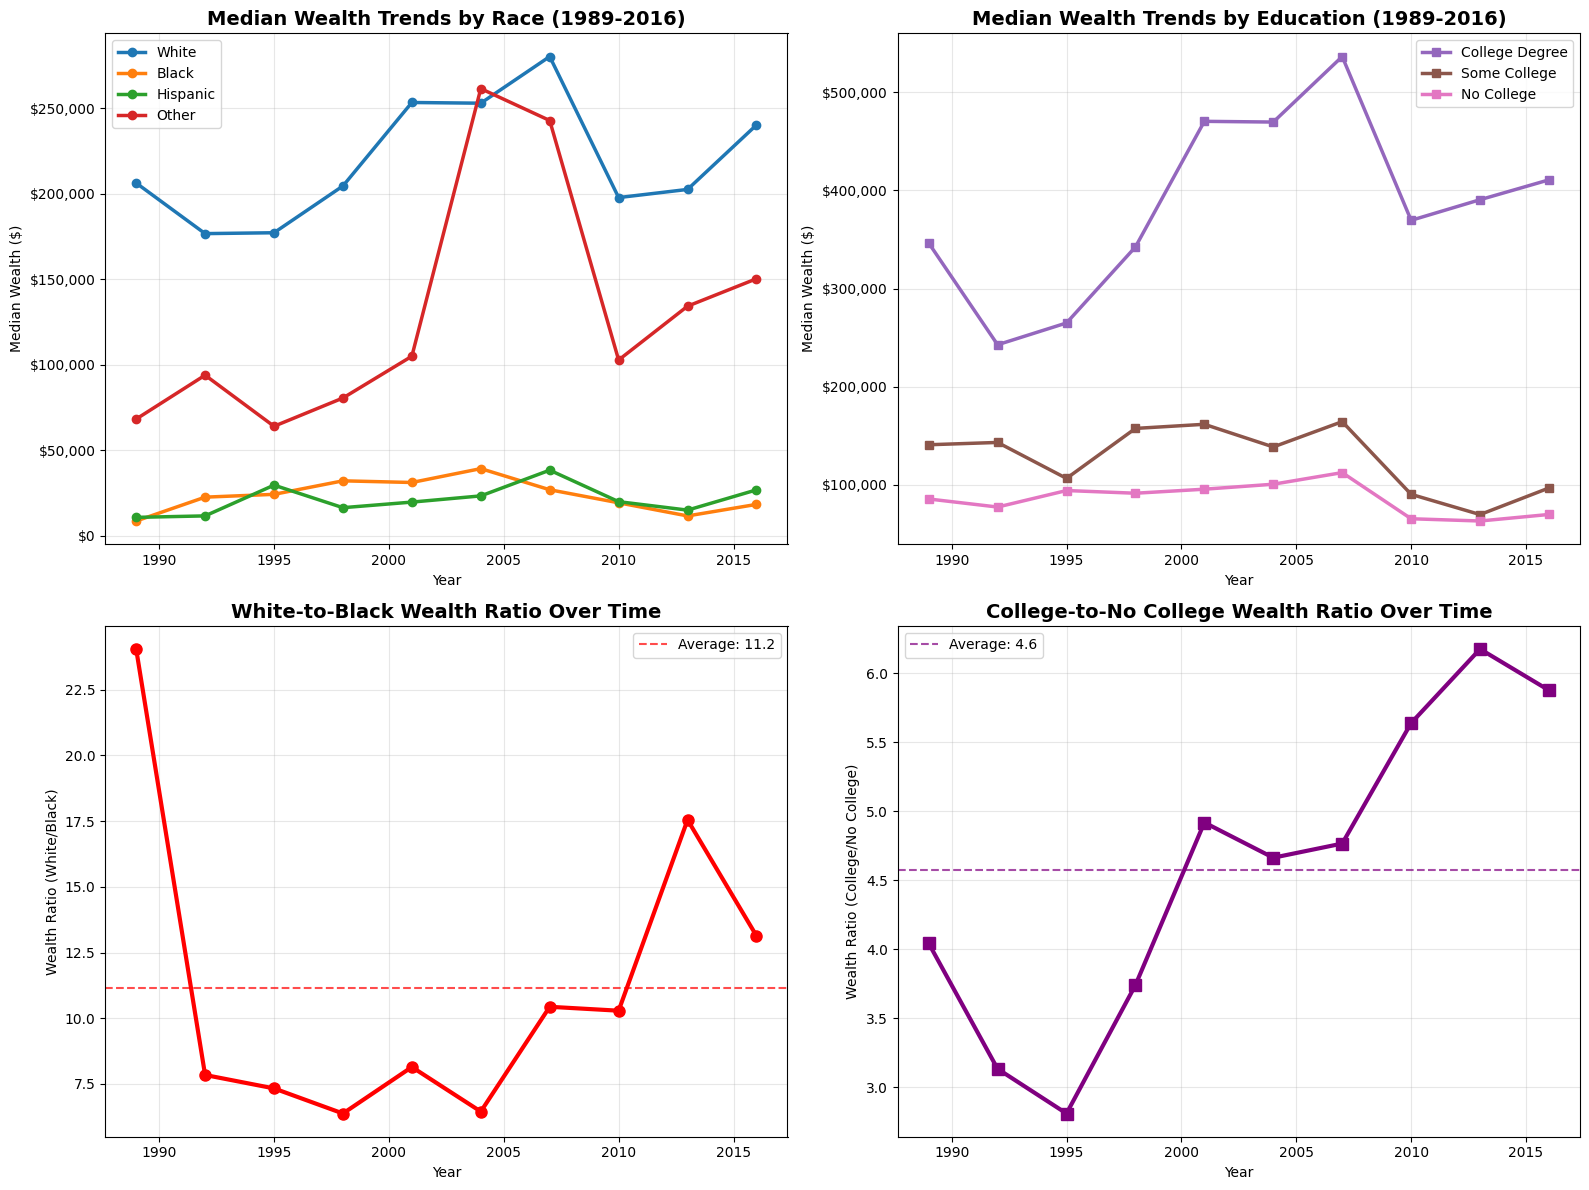

In [9]:
# Create comprehensive visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Wealth trends by race
pivot_race = wealth_by_race_df.pivot(index='year', columns='race', values='weighted_median_wealth')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, race in enumerate(['white', 'black', 'Hispanic', 'other']):
    if race in pivot_race.columns:
        ax1.plot(pivot_race.index, pivot_race[race], marker='o', linewidth=2.5, 
                label=race.title(), color=colors[i], markersize=6)

ax1.set_title('Median Wealth Trends by Race (1989-2016)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Wealth ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: Wealth trends by education
pivot_edu = wealth_by_edu_df.pivot(index='year', columns='education', values='weighted_median_wealth')
edu_colors = ['#9467bd', '#8c564b', '#e377c2']
edu_order = ['college degree', 'some college', 'no college']
for i, edu in enumerate(edu_order):
    if edu in pivot_edu.columns:
        ax2.plot(pivot_edu.index, pivot_edu[edu], marker='s', linewidth=2.5, 
                label=edu.title(), color=edu_colors[i], markersize=6)

ax2.set_title('Median Wealth Trends by Education (1989-2016)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Median Wealth ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 3: Wealth gap ratios over time (White/Black)
white_black_ratio = pivot_race['white'] / pivot_race['black']
ax3.plot(white_black_ratio.index, white_black_ratio.values, marker='o', linewidth=3, 
         color='red', markersize=8)
ax3.set_title('White-to-Black Wealth Ratio Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Wealth Ratio (White/Black)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=white_black_ratio.mean(), color='red', linestyle='--', alpha=0.7, 
           label=f'Average: {white_black_ratio.mean():.1f}')
ax3.legend()

# Plot 4: Education gap (College/No College)
college_no_college_ratio = pivot_edu['college degree'] / pivot_edu['no college']
ax4.plot(college_no_college_ratio.index, college_no_college_ratio.values, marker='s', 
         linewidth=3, color='purple', markersize=8)
ax4.set_title('College-to-No College Wealth Ratio Over Time', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Wealth Ratio (College/No College)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=college_no_college_ratio.mean(), color='purple', linestyle='--', alpha=0.7,
           label=f'Average: {college_no_college_ratio.mean():.1f}')
ax4.legend()

plt.tight_layout()
plt.show()

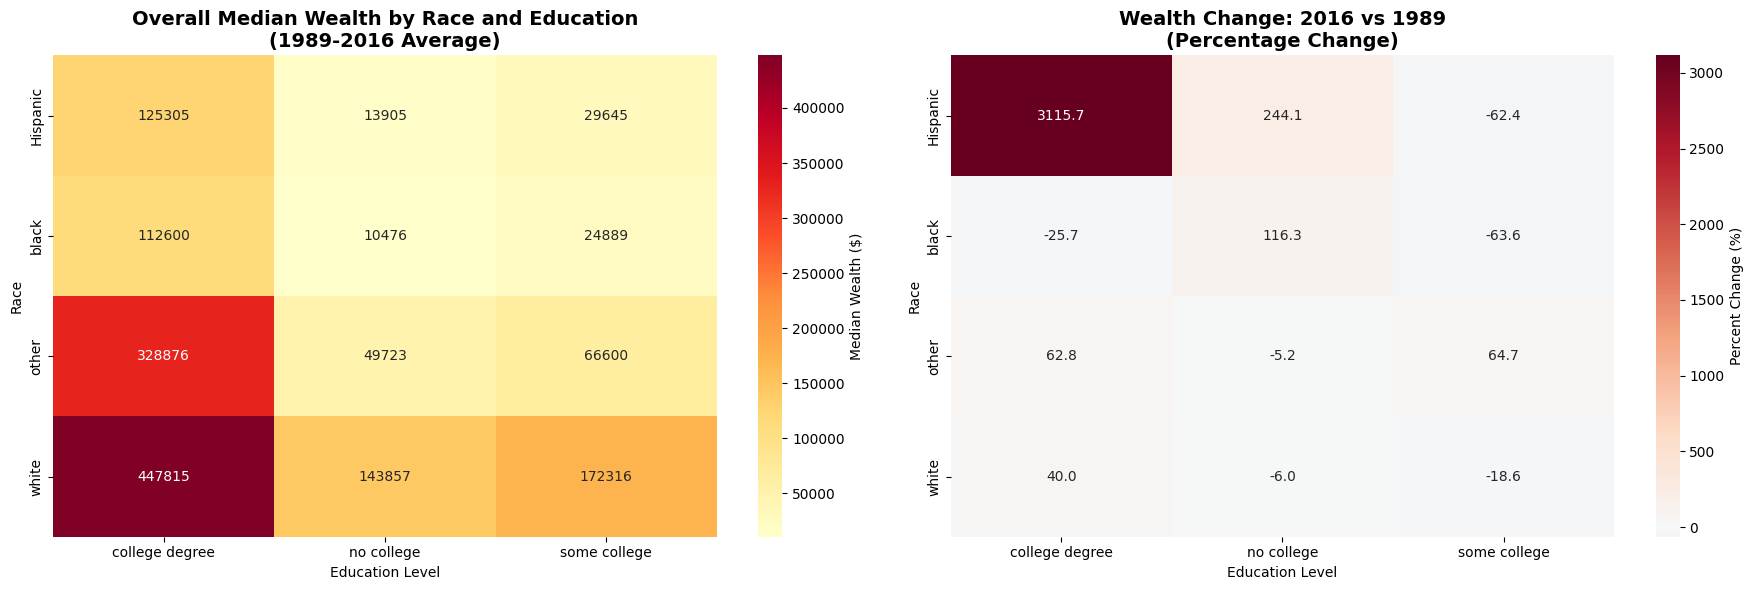

In [10]:
# Create heatmap showing wealth by race and education over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Prepare data for heatmap - Average wealth by race and education
heatmap_data = []
for race in df['race'].unique():
    for education in df['education'].unique():
        subset = df[(df['race'] == race) & (df['education'] == education)]
        if len(subset) > 0:
            weighted_med = weighted_median(subset['wealth'].values, subset['weight'].values)
            heatmap_data.append({
                'race': race,
                'education': education,
                'weighted_median_wealth': weighted_med
            })

heatmap_df = pd.DataFrame(heatmap_data)
heatmap_pivot = heatmap_df.pivot(index='race', columns='education', values='weighted_median_wealth')

# Heatmap 1: Overall wealth by race and education
sns.heatmap(heatmap_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': 'Median Wealth ($)'})
ax1.set_title('Overall Median Wealth by Race and Education\n(1989-2016 Average)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Race')
ax1.set_xlabel('Education Level')

# Create wealth change comparison (2016 vs 1989)
early_data = df[df['year'] == 1989]
recent_data = df[df['year'] == 2016]

change_data = []
for race in df['race'].unique():
    for education in df['education'].unique():
        early_subset = early_data[(early_data['race'] == race) & (early_data['education'] == education)]
        recent_subset = recent_data[(recent_data['race'] == race) & (recent_data['education'] == education)]
        
        if len(early_subset) > 0 and len(recent_subset) > 0:
            early_wealth = weighted_median(early_subset['wealth'].values, early_subset['weight'].values)
            recent_wealth = weighted_median(recent_subset['wealth'].values, recent_subset['weight'].values)
            
            if not np.isnan(early_wealth) and not np.isnan(recent_wealth):
                pct_change = ((recent_wealth - early_wealth) / early_wealth) * 100
                change_data.append({
                    'race': race,
                    'education': education,
                    'percent_change': pct_change
                })

change_df = pd.DataFrame(change_data)
change_pivot = change_df.pivot(index='race', columns='education', values='percent_change')

# Heatmap 2: Percentage change in wealth (2016 vs 1989)
sns.heatmap(change_pivot, annot=True, fmt='.1f', cmap='RdBu_r', center=0, ax=ax2,
            cbar_kws={'label': 'Percent Change (%)'})
ax2.set_title('Wealth Change: 2016 vs 1989\n(Percentage Change)', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Race')
ax2.set_xlabel('Education Level')

plt.tight_layout()
plt.show()

In [21]:
# Quantitative Analysis of Trends
print("=== QUANTITATIVE TREND ANALYSIS ===\n")

# Calculate compound annual growth rates (CAGR) for each group
def calculate_cagr(start_value, end_value, years):
    if start_value <= 0 or end_value <= 0:
        return np.nan
    return ((end_value / start_value) ** (1/years) - 1) * 100

years_span = 2016 - 1989

print("1. COMPOUND ANNUAL GROWTH RATES (1989-2016):")
print("   Race Groups:")
for race in ['white', 'black', 'Hispanic', 'other']:
    start_val = pivot_race.loc[1989, race] if race in pivot_race.columns else np.nan
    end_val = pivot_race.loc[2016, race] if race in pivot_race.columns else np.nan
    cagr = calculate_cagr(start_val, end_val, years_span)
    print(f"   - {race.title()}: {cagr:.2f}% per year")

print("\n   Education Groups:")
for edu in ['college degree', 'some college', 'no college']:
    start_val = pivot_edu.loc[1989, edu] if edu in pivot_edu.columns else np.nan
    end_val = pivot_edu.loc[2016, edu] if edu in pivot_edu.columns else np.nan
    cagr = calculate_cagr(start_val, end_val, years_span)
    print(f"   - {edu.title()}: {cagr:.2f}% per year")

# Gap analysis
print("\n2. WEALTH GAP ANALYSIS:")
white_black_1989 = pivot_race.loc[1989, 'white'] / pivot_race.loc[1989, 'black']
white_black_2016 = pivot_race.loc[2016, 'white'] / pivot_race.loc[2016, 'black']
print(f"   White-to-Black Ratio: {white_black_1989:.1f} (1989) → {white_black_2016:.1f} (2016)")

college_no_college_1989 = pivot_edu.loc[1989, 'college degree'] / pivot_edu.loc[1989, 'no college']
college_no_college_2016 = pivot_edu.loc[2016, 'college degree'] / pivot_edu.loc[2016, 'no college']
print(f"   College-to-No College Ratio: {college_no_college_1989:.1f} (1989) → {college_no_college_2016:.1f} (2016)")

# Volatility analysis (coefficient of variation)
print("\n3. WEALTH VOLATILITY (Coefficient of Variation):")
print("   Race Groups:")
for race in ['white', 'black', 'Hispanic', 'other']:
    if race in pivot_race.columns:
        cv = (pivot_race[race].std() / pivot_race[race].mean()) * 100
        print(f"   - {race.title()}: {cv:.1f}%")

print("\n   Education Groups:")
for edu in ['college degree', 'some college', 'no college']:
    if edu in pivot_edu.columns:
        cv = (pivot_edu[edu].std() / pivot_edu[edu].mean()) * 100
        print(f"   - {edu.title()}: {cv:.1f}%")

# Crisis impact analysis (2007-2010)
print("\n4. FINANCIAL CRISIS IMPACT (2007-2010):")
print("   Race Groups:")
for race in ['white', 'black', 'Hispanic', 'other']:
    if race in pivot_race.columns:
        crisis_decline = ((pivot_race.loc[2010, race] - pivot_race.loc[2007, race]) / pivot_race.loc[2007, race]) * 100
        print(f"   - {race.title()}: {crisis_decline:.1f}%")

print("\n   Education Groups:")
for edu in ['college degree', 'some college', 'no college']:
    if edu in pivot_edu.columns:
        crisis_decline = ((pivot_edu.loc[2010, edu] - pivot_edu.loc[2007, edu]) / pivot_edu.loc[2007, edu]) * 100
        print(f"   - {edu.title()}: {crisis_decline:.1f}%")

print("\n=== END ANALYSIS ===")  

=== QUANTITATIVE TREND ANALYSIS ===

1. COMPOUND ANNUAL GROWTH RATES (1989-2016):
   Race Groups:
   - White: 0.57% per year
   - Black: 2.84% per year
   - Hispanic: 3.46% per year
   - Other: 2.97% per year

   Education Groups:
   - College Degree: 0.63% per year
   - Some College: -1.38% per year
   - No College: -0.75% per year

2. WEALTH GAP ANALYSIS:
   White-to-Black Ratio: 24.0 (1989) → 13.1 (2016)
   College-to-No College Ratio: 4.0 (1989) → 5.9 (2016)

3. WEALTH VOLATILITY (Coefficient of Variation):
   Race Groups:
   - White: 16.1%
   - Black: 40.4%
   - Hispanic: 40.8%
   - Other: 53.5%

   Education Groups:
   - College Degree: 23.9%
   - Some College: 26.3%
   - No College: 19.0%

4. FINANCIAL CRISIS IMPACT (2007-2010):
   Race Groups:
   - White: -29.4%
   - Black: -28.4%
   - Hispanic: -48.1%
   - Other: -57.7%

   Education Groups:
   - College Degree: -31.1%
   - Some College: -45.0%
   - No College: -41.8%

=== END ANALYSIS ===


# Housing Wealth Analysis: Black vs White Households (1989-2016)

This section focuses specifically on median housing wealth trends for Black and White households, using weighted medians to ensure population-representative results.

In [12]:
# Calculate weighted median housing wealth by race and year (Black and White only)
housing_wealth_by_race = []

# Focus on Black and White households only
target_races = ['black', 'white']

for year in sorted(df['year'].unique()):
    for race in target_races:
        subset = df[(df['year'] == year) & (df['race'] == race)]
        if len(subset) > 0:
            # Use asset_housing for housing wealth
            weighted_med_housing = weighted_median(subset['asset_housing'].values, subset['weight'].values)
            housing_wealth_by_race.append({
                'year': year,
                'race': race,
                'weighted_median_housing_wealth': weighted_med_housing,
                'sample_size': len(subset)
            })

housing_wealth_df = pd.DataFrame(housing_wealth_by_race)
housing_pivot = housing_wealth_df.pivot(index='year', columns='race', values='weighted_median_housing_wealth')

print("Weighted median housing wealth by race and year (Black vs White):")
print(housing_pivot.round(0))
print(f"\nData covers {len(df)} total observations from {df['year'].min()} to {df['year'].max()}")
print(f"Analysis focuses on {len(df[df['race'].isin(target_races)])} Black and White households")

Weighted median housing wealth by race and year (Black vs White):
race   black     white
year                  
1989     0.0   93293.0
1992     0.0   92239.0
1995     0.0  101790.0
1998     0.0  115086.0
2001     0.0  121937.0
2004  7631.0  158973.0
2007     0.0  162122.0
2010     0.0  138166.0
2013     0.0  128888.0
2016     0.0  130000.0

Data covers 47776 total observations from 1989 to 2016
Analysis focuses on 42230 Black and White households


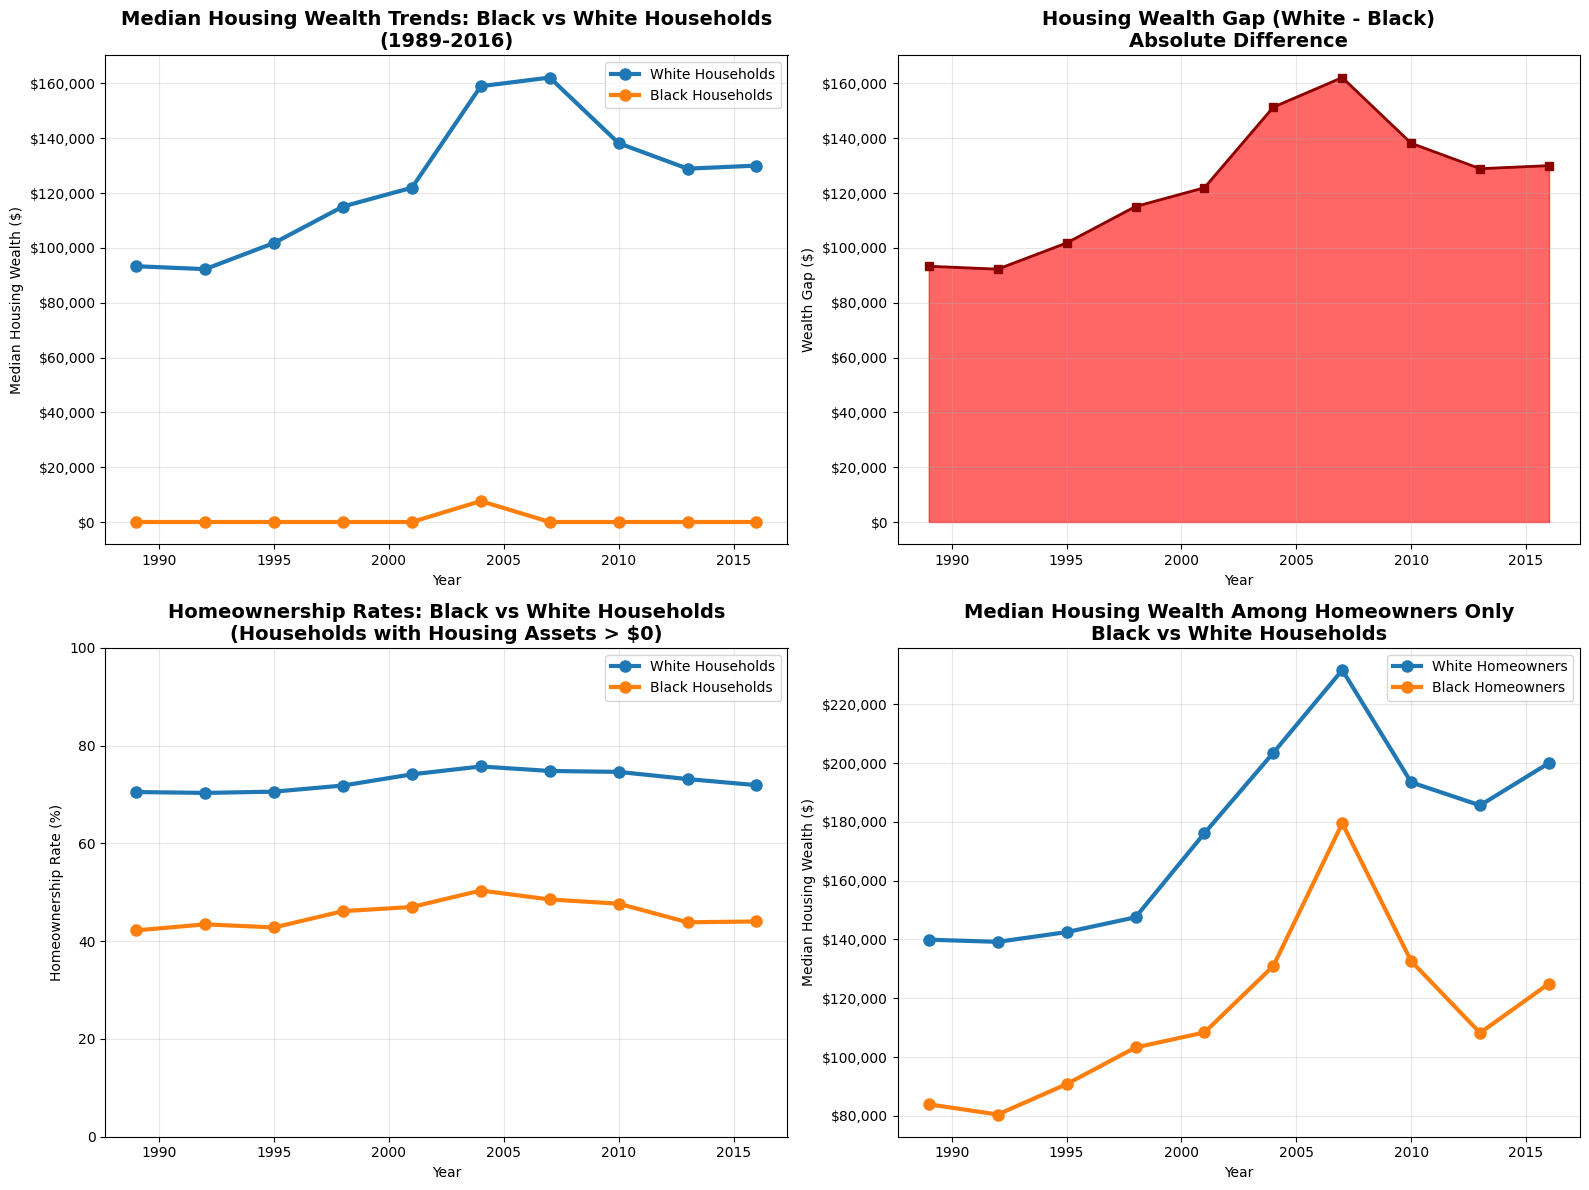

Homeownership rates by race and year:
race  black  white
year              
1989   42.2   70.5
1992   43.4   70.3
1995   42.8   70.6
1998   46.1   71.8
2001   47.0   74.1
2004   50.4   75.7
2007   48.5   74.8
2010   47.7   74.6
2013   43.9   73.2
2016   44.0   71.9


In [13]:
# Create comprehensive visualizations for housing wealth
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Housing wealth trends by race
colors_race = ['#1f77b4', '#ff7f0e']  # Blue for White, Orange for Black
for i, race in enumerate(['white', 'black']):
    if race in housing_pivot.columns:
        ax1.plot(housing_pivot.index, housing_pivot[race], marker='o', linewidth=3, 
                label=f'{race.title()} Households', color=colors_race[i], markersize=8)

ax1.set_title('Median Housing Wealth Trends: Black vs White Households\n(1989-2016)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Housing Wealth ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: Housing wealth gap (absolute difference)
white_housing = housing_pivot['white']
black_housing = housing_pivot['black']
housing_gap = white_housing - black_housing

ax2.fill_between(housing_gap.index, 0, housing_gap.values, alpha=0.6, color='red')
ax2.plot(housing_gap.index, housing_gap.values, marker='s', linewidth=2, 
         color='darkred', markersize=6)
ax2.set_title('Housing Wealth Gap (White - Black)\nAbsolute Difference', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Wealth Gap ($)')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 3: Homeownership rates (implied from zero housing wealth)
# Calculate percentage with zero housing wealth as proxy for non-homeownership
homeownership_data = []
for year in sorted(df['year'].unique()):
    for race in ['black', 'white']:
        subset = df[(df['year'] == year) & (df['race'] == race)]
        if len(subset) > 0:
            # Calculate weighted percentage with housing wealth > 0
            has_housing = subset['asset_housing'] > 0
            weighted_homeownership = np.average(has_housing, weights=subset['weight']) * 100
            homeownership_data.append({
                'year': year,
                'race': race,
                'homeownership_rate': weighted_homeownership
            })

homeownership_df = pd.DataFrame(homeownership_data)
homeownership_pivot = homeownership_df.pivot(index='year', columns='race', values='homeownership_rate')

for i, race in enumerate(['white', 'black']):
    if race in homeownership_pivot.columns:
        ax3.plot(homeownership_pivot.index, homeownership_pivot[race], marker='o', linewidth=3, 
                label=f'{race.title()} Households', color=colors_race[i], markersize=8)

ax3.set_title('Homeownership Rates: Black vs White Households\n(Households with Housing Assets > $0)', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Homeownership Rate (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 100)

# Plot 4: Housing wealth among homeowners only
homeowner_housing_data = []
for year in sorted(df['year'].unique()):
    for race in ['black', 'white']:
        # Filter to only those with housing assets > 0
        subset = df[(df['year'] == year) & (df['race'] == race) & (df['asset_housing'] > 0)]
        if len(subset) > 0:
            weighted_med_housing = weighted_median(subset['asset_housing'].values, subset['weight'].values)
            homeowner_housing_data.append({
                'year': year,
                'race': race,
                'median_housing_wealth_homeowners': weighted_med_housing,
                'homeowner_sample_size': len(subset)
            })

homeowner_housing_df = pd.DataFrame(homeowner_housing_data)
homeowner_pivot = homeowner_housing_df.pivot(index='year', columns='race', values='median_housing_wealth_homeowners')

for i, race in enumerate(['white', 'black']):
    if race in homeowner_pivot.columns:
        ax4.plot(homeowner_pivot.index, homeowner_pivot[race], marker='o', linewidth=3, 
                label=f'{race.title()} Homeowners', color=colors_race[i], markersize=8)

ax4.set_title('Median Housing Wealth Among Homeowners Only\nBlack vs White Households', 
              fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Median Housing Wealth ($)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("Homeownership rates by race and year:")
print(homeownership_pivot.round(1))

In [14]:
# Quantitative Analysis of Housing Wealth Trends
print("=== HOUSING WEALTH ANALYSIS: BLACK vs WHITE HOUSEHOLDS ===\n")

# Calculate key statistics
print("1. MEDIAN HOUSING WEALTH AMONG ALL HOUSEHOLDS:")
print("   White households (1989):", f"${housing_pivot.loc[1989, 'white']:,.0f}")
print("   White households (2016):", f"${housing_pivot.loc[2016, 'white']:,.0f}")
print("   Black households (1989):", f"${housing_pivot.loc[1989, 'black']:,.0f}")
print("   Black households (2016):", f"${housing_pivot.loc[2016, 'black']:,.0f}")

# CAGR for housing wealth
white_housing_cagr = calculate_cagr(housing_pivot.loc[1989, 'white'], 
                                   housing_pivot.loc[2016, 'white'], years_span)
print(f"\n   White Housing Wealth CAGR: {white_housing_cagr:.2f}% per year")

# Since Black median is mostly 0, calculate differently
black_housing_values = housing_pivot['black'].dropna()
black_positive_years = black_housing_values[black_housing_values > 0]
print(f"   Black households had positive median housing wealth in {len(black_positive_years)} of {len(black_housing_values)} years")

print("\n2. HOMEOWNERSHIP RATES:")
print("   White households:")
print(f"     1989: {homeownership_pivot.loc[1989, 'white']:.1f}%")
print(f"     2016: {homeownership_pivot.loc[2016, 'white']:.1f}%")
print(f"     Average: {homeownership_pivot['white'].mean():.1f}%")

print("   Black households:")
print(f"     1989: {homeownership_pivot.loc[1989, 'black']:.1f}%")
print(f"     2016: {homeownership_pivot.loc[2016, 'black']:.1f}%")
print(f"     Average: {homeownership_pivot['black'].mean():.1f}%")

# Homeownership gap
homeownership_gap = homeownership_pivot['white'] - homeownership_pivot['black']
print(f"\n   Homeownership Gap (White - Black):")
print(f"     1989: {homeownership_gap.loc[1989]:.1f} percentage points")
print(f"     2016: {homeownership_gap.loc[2016]:.1f} percentage points")
print(f"     Average: {homeownership_gap.mean():.1f} percentage points")

print("\n3. MEDIAN HOUSING WEALTH AMONG HOMEOWNERS ONLY:")
print("   White homeowners:")
print(f"     1989: ${homeowner_pivot.loc[1989, 'white']:,.0f}")
print(f"     2016: ${homeowner_pivot.loc[2016, 'white']:,.0f}")

print("   Black homeowners:")
print(f"     1989: ${homeowner_pivot.loc[1989, 'black']:,.0f}")
print(f"     2016: ${homeowner_pivot.loc[2016, 'black']:,.0f}")

# Calculate ratio among homeowners
homeowner_ratio_1989 = homeowner_pivot.loc[1989, 'white'] / homeowner_pivot.loc[1989, 'black']
homeowner_ratio_2016 = homeowner_pivot.loc[2016, 'white'] / homeowner_pivot.loc[2016, 'black']
print(f"\n   White-to-Black Housing Wealth Ratio (among homeowners):")
print(f"     1989: {homeowner_ratio_1989:.1f}")
print(f"     2016: {homeowner_ratio_2016:.1f}")

# Housing wealth volatility
print("\n4. HOUSING WEALTH VOLATILITY (Coefficient of Variation):")
white_housing_cv = (housing_pivot['white'].std() / housing_pivot['white'].mean()) * 100
print(f"   White households: {white_housing_cv:.1f}%")

# For Black households, calculate CV among homeowners since median is often 0
black_homeowner_cv = (homeowner_pivot['black'].std() / homeowner_pivot['black'].mean()) * 100
print(f"   Black homeowners: {black_homeowner_cv:.1f}%")

print("\n=== END HOUSING WEALTH ANALYSIS ===")  

=== HOUSING WEALTH ANALYSIS: BLACK vs WHITE HOUSEHOLDS ===

1. MEDIAN HOUSING WEALTH AMONG ALL HOUSEHOLDS:
   White households (1989): $93,293
   White households (2016): $130,000
   Black households (1989): $0
   Black households (2016): $0

   White Housing Wealth CAGR: 1.24% per year
   Black households had positive median housing wealth in 1 of 10 years

2. HOMEOWNERSHIP RATES:
   White households:
     1989: 70.5%
     2016: 71.9%
     Average: 72.8%
   Black households:
     1989: 42.2%
     2016: 44.0%
     Average: 45.6%

   Homeownership Gap (White - Black):
     1989: 28.3 percentage points
     2016: 27.9 percentage points
     Average: 27.2 percentage points

3. MEDIAN HOUSING WEALTH AMONG HOMEOWNERS ONLY:
   White homeowners:
     1989: $139,940
     2016: $200,000
   Black homeowners:
     1989: $83,964
     2016: $125,000

   White-to-Black Housing Wealth Ratio (among homeowners):
     1989: 1.7
     2016: 1.6

4. HOUSING WEALTH VOLATILITY (Coefficient of Variation):
   

In [15]:
# HOMEOWNERS AGED 25+ ANALYSIS: Housing vs Non-Housing Wealth
print("=== HOMEOWNERS AGED 25+ WEALTH ANALYSIS ===\n")

# Filter to homeowners aged 25 or older (those with housing assets > 0 and age >= 25)
homeowners_25plus = df[(df['asset_housing'] > 0) & (df['age'] >= 25)].copy()

print(f"Filtered dataset: {len(homeowners_25plus):,} homeowners aged 25+ out of {len(df):,} total observations")
print(f"Represents {len(homeowners_25plus)/len(df)*100:.1f}% of the full dataset")

# Create non-housing wealth variable
homeowners_25plus['non_housing_wealth'] = homeowners_25plus['asset_total'] - homeowners_25plus['asset_housing'] - homeowners_25plus['debt_total'] + homeowners_25plus['debt_housing']

print(f"\nRace distribution among homeowners 25+:")
race_dist = homeowners_25plus.groupby('race').size().sort_values(ascending=False)
for race, count in race_dist.items():
    pct = (count / len(homeowners_25plus)) * 100
    print(f"  {race.title()}: {count:,} ({pct:.1f}%)")

# Focus on Black and White homeowners for detailed analysis
target_races = ['black', 'white']
bw_homeowners = homeowners_25plus[homeowners_25plus['race'].isin(target_races)].copy()

print(f"\nBlack and White homeowners 25+: {len(bw_homeowners):,} observations")

# Calculate median housing and non-housing wealth by race and year
housing_nonhousing_data = []

for year in sorted(bw_homeowners['year'].unique()):
    for race in target_races:
        subset = bw_homeowners[(bw_homeowners['year'] == year) & (bw_homeowners['race'] == race)]
        if len(subset) > 0:
            # Housing wealth
            housing_wealth_med = weighted_median(subset['asset_housing'].values, subset['weight'].values)
            
            # Non-housing wealth
            nonhousing_wealth_med = weighted_median(subset['non_housing_wealth'].values, subset['weight'].values)
            
            housing_nonhousing_data.append({
                'year': year,
                'race': race,
                'median_housing_wealth': housing_wealth_med,
                'median_nonhousing_wealth': nonhousing_wealth_med,
                'sample_size': len(subset)
            })

hn_df = pd.DataFrame(housing_nonhousing_data)

# Create pivot tables
housing_pivot_owners = hn_df.pivot(index='year', columns='race', values='median_housing_wealth')
nonhousing_pivot_owners = hn_df.pivot(index='year', columns='race', values='median_nonhousing_wealth')

print("\n1. MEDIAN HOUSING WEALTH AMONG HOMEOWNERS 25+ (by race and year):")
print(housing_pivot_owners.round(0))

print("\n2. MEDIAN NON-HOUSING WEALTH AMONG HOMEOWNERS 25+ (by race and year):")
print(nonhousing_pivot_owners.round(0))

=== HOMEOWNERS AGED 25+ WEALTH ANALYSIS ===

Filtered dataset: 33,292 homeowners aged 25+ out of 47,776 total observations
Represents 69.7% of the full dataset

Race distribution among homeowners 25+:
  White: 28,370 (85.2%)
  Black: 2,105 (6.3%)
  Hispanic: 1,570 (4.7%)
  Other: 1,247 (3.7%)

Black and White homeowners 25+: 30,475 observations

1. MEDIAN HOUSING WEALTH AMONG HOMEOWNERS 25+ (by race and year):
race     black     white
year                    
1989   83964.0  139940.0
1992   80499.0  142551.0
1995   93960.0  144072.0
1998  103282.0  147546.0
2001  108388.0  176131.0
2004  130994.0  209844.0
2007  173702.0  231603.0
2010  132639.0  193433.0
2013  108266.0  185599.0
2016  125000.0  200000.0

2. MEDIAN NON-HOUSING WEALTH AMONG HOMEOWNERS 25+ (by race and year):
race    black     white
year                   
1989  12128.0   81725.0
1992  16603.0   70185.0
1995  20828.0   80179.0
1998  27517.0  113758.0
2001  32462.0  146053.0
2004  20984.0  121964.0
2007  40299.0  124371.0

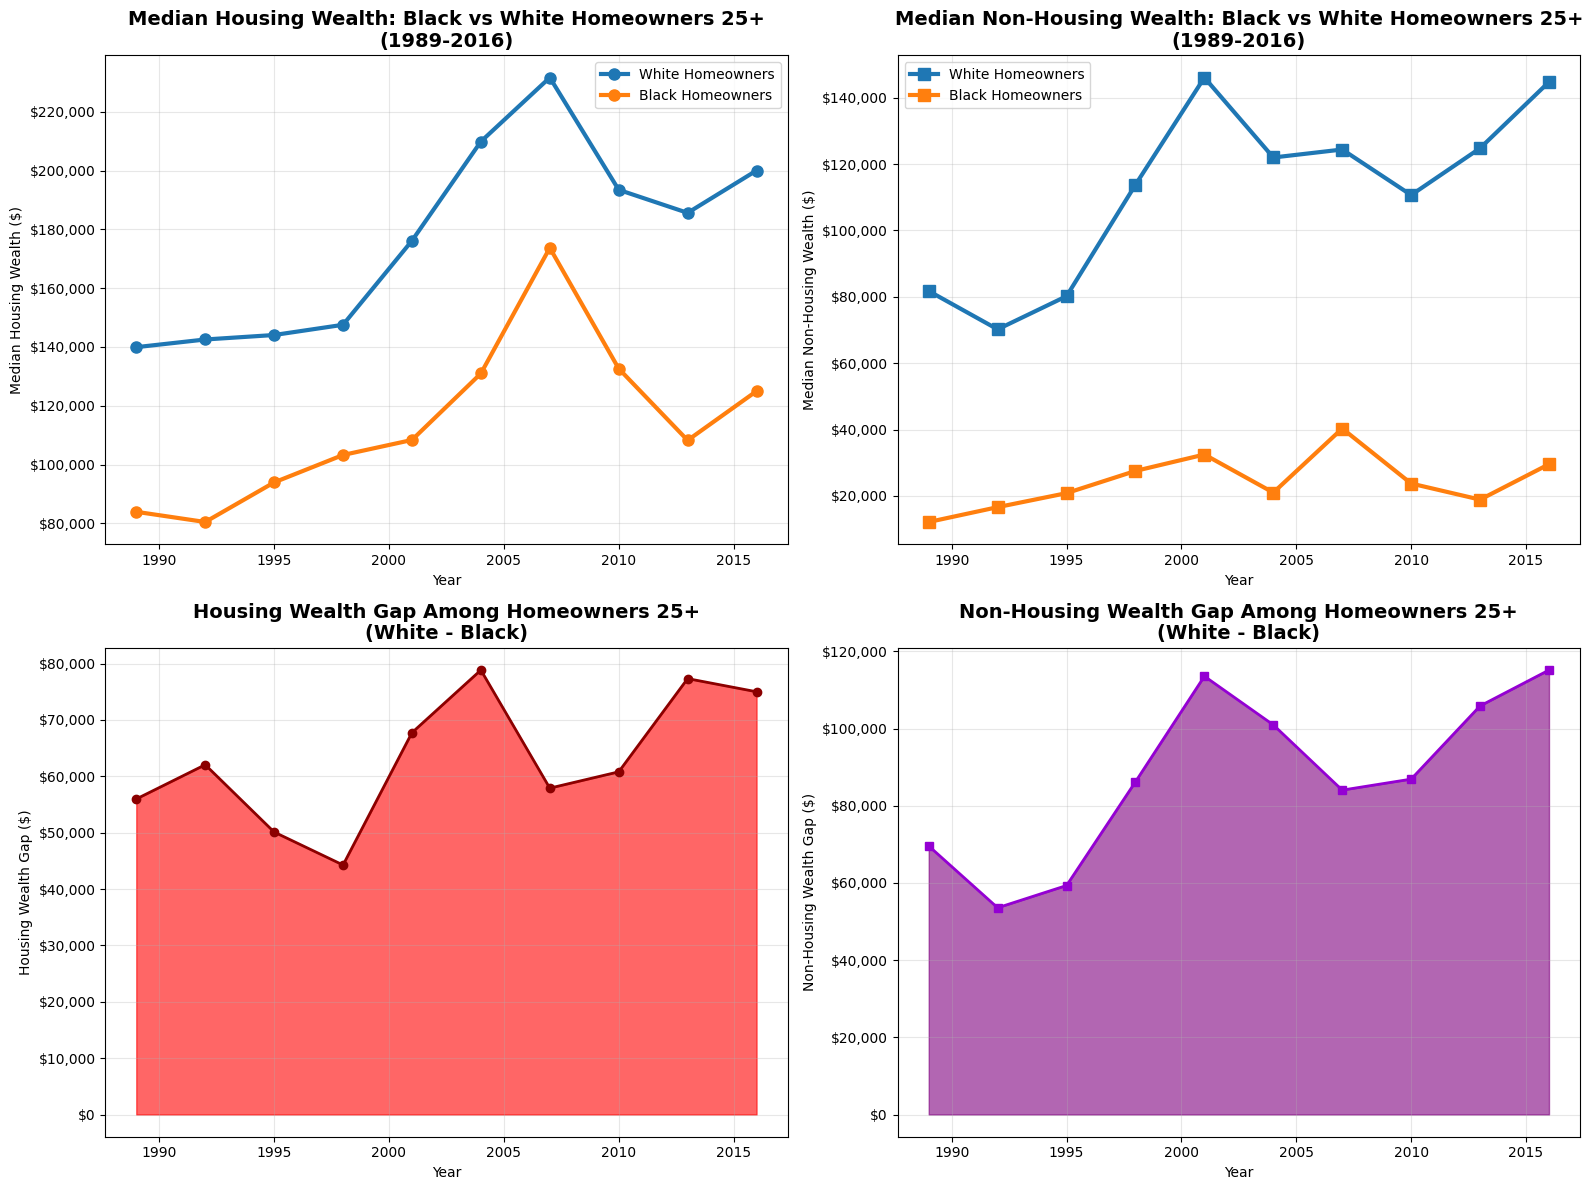


=== FINANCIAL CRISIS IMPACT ANALYSIS (2007 Base) ===

3. HOUSING WEALTH LOSSES (2007-2010):
   White homeowners 25+:
     2007: $231,603
     2010: $193,433
     Dollar loss: $38,170
     Proportional loss: 16.5%

   Black homeowners 25+:
     2007: $173,702
     2010: $132,639
     Dollar loss: $41,063
     Proportional loss: 23.6%

4. NON-HOUSING WEALTH CHANGES (2007-2010):
   White homeowners 25+:
     2007: $124,371
     2010: $110,643
     Dollar change: $-13,727
     Proportional change: -11.0%

   Black homeowners 25+:
     2007: $40,299
     2010: $23,720
     Dollar change: $-16,579
     Proportional change: -41.1%

5. CRISIS IMPACT SUMMARY:
   Largest housing wealth loss in DOLLAR terms:
     BLACK homeowners: $41,063 loss
     vs White homeowners: $38,170 loss
     Black homeowners lost $2,892 more

   Largest housing wealth loss in PROPORTIONAL terms:
     BLACK homeowners: 23.6% loss
     vs White homeowners: 16.5% loss
     Black homeowners lost 7.2 percentage points mor

In [16]:
# Create comprehensive visualizations for homeowners 25+
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Housing wealth trends for homeowners 25+
colors_race = ['#1f77b4', '#ff7f0e']  # Blue for White, Orange for Black
for i, race in enumerate(['white', 'black']):
    if race in housing_pivot_owners.columns:
        ax1.plot(housing_pivot_owners.index, housing_pivot_owners[race], marker='o', linewidth=3, 
                label=f'{race.title()} Homeowners', color=colors_race[i], markersize=8)

ax1.set_title('Median Housing Wealth: Black vs White Homeowners 25+\n(1989-2016)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Housing Wealth ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: Non-housing wealth trends for homeowners 25+
for i, race in enumerate(['white', 'black']):
    if race in nonhousing_pivot_owners.columns:
        ax2.plot(nonhousing_pivot_owners.index, nonhousing_pivot_owners[race], marker='s', linewidth=3, 
                label=f'{race.title()} Homeowners', color=colors_race[i], markersize=8)

ax2.set_title('Median Non-Housing Wealth: Black vs White Homeowners 25+\n(1989-2016)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Median Non-Housing Wealth ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 3: Housing wealth gap between races
housing_gap_owners = housing_pivot_owners['white'] - housing_pivot_owners['black']
ax3.fill_between(housing_gap_owners.index, 0, housing_gap_owners.values, alpha=0.6, color='red')
ax3.plot(housing_gap_owners.index, housing_gap_owners.values, marker='o', linewidth=2, 
         color='darkred', markersize=6)
ax3.set_title('Housing Wealth Gap Among Homeowners 25+\n(White - Black)', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Housing Wealth Gap ($)')
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 4: Non-housing wealth gap between races
nonhousing_gap_owners = nonhousing_pivot_owners['white'] - nonhousing_pivot_owners['black']
ax4.fill_between(nonhousing_gap_owners.index, 0, nonhousing_gap_owners.values, alpha=0.6, color='purple')
ax4.plot(nonhousing_gap_owners.index, nonhousing_gap_owners.values, marker='s', linewidth=2, 
         color='darkviolet', markersize=6)
ax4.set_title('Non-Housing Wealth Gap Among Homeowners 25+\n(White - Black)', 
              fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Non-Housing Wealth Gap ($)')
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# FINANCIAL CRISIS ANALYSIS (2007 as base period)
print("\n=== FINANCIAL CRISIS IMPACT ANALYSIS (2007 Base) ===\n")

# Get 2007 and 2010 values for comparison
crisis_years = [2007, 2010]

# Housing wealth losses
print("3. HOUSING WEALTH LOSSES (2007-2010):")
for race in ['white', 'black']:
    if race in housing_pivot_owners.columns:
        housing_2007 = housing_pivot_owners.loc[2007, race]
        housing_2010 = housing_pivot_owners.loc[2010, race]
        
        # Dollar loss
        dollar_loss = housing_2007 - housing_2010
        
        # Proportional loss
        prop_loss = (dollar_loss / housing_2007) * 100
        
        print(f"   {race.title()} homeowners 25+:")
        print(f"     2007: ${housing_2007:,.0f}")
        print(f"     2010: ${housing_2010:,.0f}")
        print(f"     Dollar loss: ${dollar_loss:,.0f}")
        print(f"     Proportional loss: {prop_loss:.1f}%")
        print()

# Non-housing wealth changes
print("4. NON-HOUSING WEALTH CHANGES (2007-2010):")
for race in ['white', 'black']:
    if race in nonhousing_pivot_owners.columns:
        nonhousing_2007 = nonhousing_pivot_owners.loc[2007, race]
        nonhousing_2010 = nonhousing_pivot_owners.loc[2010, race]
        
        # Dollar change
        dollar_change = nonhousing_2010 - nonhousing_2007
        
        # Proportional change (handle negative values carefully)
        if nonhousing_2007 != 0:
            prop_change = (dollar_change / abs(nonhousing_2007)) * 100
        else:
            prop_change = np.nan
        
        print(f"   {race.title()} homeowners 25+:")
        print(f"     2007: ${nonhousing_2007:,.0f}")
        print(f"     2010: ${nonhousing_2010:,.0f}")
        print(f"     Dollar change: ${dollar_change:,.0f}")
        if not np.isnan(prop_change):
            print(f"     Proportional change: {prop_change:.1f}%")
        else:
            print(f"     Proportional change: N/A (zero base)")
        print()

# Summary comparison
print("5. CRISIS IMPACT SUMMARY:")
white_housing_loss = housing_pivot_owners.loc[2007, 'white'] - housing_pivot_owners.loc[2010, 'white']
black_housing_loss = housing_pivot_owners.loc[2007, 'black'] - housing_pivot_owners.loc[2010, 'black']

white_housing_prop_loss = (white_housing_loss / housing_pivot_owners.loc[2007, 'white']) * 100
black_housing_prop_loss = (black_housing_loss / housing_pivot_owners.loc[2007, 'black']) * 100

print(f"   Largest housing wealth loss in DOLLAR terms:")
if white_housing_loss > black_housing_loss:
    print(f"     WHITE homeowners: ${white_housing_loss:,.0f} loss")
    print(f"     vs Black homeowners: ${black_housing_loss:,.0f} loss")
    print(f"     White homeowners lost ${white_housing_loss - black_housing_loss:,.0f} more")
else:
    print(f"     BLACK homeowners: ${black_housing_loss:,.0f} loss")
    print(f"     vs White homeowners: ${white_housing_loss:,.0f} loss")
    print(f"     Black homeowners lost ${black_housing_loss - white_housing_loss:,.0f} more")

print(f"\n   Largest housing wealth loss in PROPORTIONAL terms:")
if white_housing_prop_loss > black_housing_prop_loss:
    print(f"     WHITE homeowners: {white_housing_prop_loss:.1f}% loss")
    print(f"     vs Black homeowners: {black_housing_prop_loss:.1f}% loss")
    print(f"     White homeowners lost {white_housing_prop_loss - black_housing_prop_loss:.1f} percentage points more")
else:
    print(f"     BLACK homeowners: {black_housing_prop_loss:.1f}% loss")
    print(f"     vs White homeowners: {white_housing_prop_loss:.1f}% loss")
    print(f"     Black homeowners lost {black_housing_prop_loss - white_housing_prop_loss:.1f} percentage points more")

In [17]:
# COMPREHENSIVE TREND ANALYSIS FOR HOMEOWNERS 25+
print("=== COMPREHENSIVE TREND ANALYSIS: HOMEOWNERS 25+ ===\n")

# Calculate growth rates for the full period
years_span = 2016 - 1989

# Housing wealth growth
print("6. LONG-TERM GROWTH RATES (1989-2016):")
print("   Housing Wealth:")
for race in ['white', 'black']:
    if race in housing_pivot_owners.columns:
        start_val = housing_pivot_owners.loc[1989, race]
        end_val = housing_pivot_owners.loc[2016, race]
        cagr = calculate_cagr(start_val, end_val, years_span)
        total_growth = ((end_val - start_val) / start_val) * 100
        print(f"     {race.title()}: {cagr:.2f}% CAGR, {total_growth:.1f}% total growth")

print("\n   Non-Housing Wealth:")
for race in ['white', 'black']:
    if race in nonhousing_pivot_owners.columns:
        start_val = nonhousing_pivot_owners.loc[1989, race]
        end_val = nonhousing_pivot_owners.loc[2016, race]
        
        # Handle negative values more carefully
        if start_val > 0 and end_val > 0:
            cagr = calculate_cagr(start_val, end_val, years_span)
            total_growth = ((end_val - start_val) / start_val) * 100
            print(f"     {race.title()}: {cagr:.2f}% CAGR, {total_growth:.1f}% total growth")
        else:
            dollar_change = end_val - start_val
            print(f"     {race.title()}: ${dollar_change:,.0f} absolute change (negative base values)")

# Wealth composition analysis
print("\n7. WEALTH COMPOSITION ANALYSIS:")
print("   1989 - Housing vs Non-Housing Wealth Ratios:")
for race in ['white', 'black']:
    housing_1989 = housing_pivot_owners.loc[1989, race]
    nonhousing_1989 = nonhousing_pivot_owners.loc[1989, race]
    total_1989 = housing_1989 + nonhousing_1989
    
    housing_pct = (housing_1989 / total_1989) * 100 if total_1989 > 0 else 0
    nonhousing_pct = (nonhousing_1989 / total_1989) * 100 if total_1989 > 0 else 0
    
    print(f"     {race.title()}: {housing_pct:.1f}% housing, {nonhousing_pct:.1f}% non-housing")

print("\n   2016 - Housing vs Non-Housing Wealth Ratios:")
for race in ['white', 'black']:
    housing_2016 = housing_pivot_owners.loc[2016, race]
    nonhousing_2016 = nonhousing_pivot_owners.loc[2016, race]
    total_2016 = housing_2016 + nonhousing_2016
    
    housing_pct = (housing_2016 / total_2016) * 100 if total_2016 > 0 else 0
    nonhousing_pct = (nonhousing_2016 / total_2016) * 100 if total_2016 > 0 else 0
    
    print(f"     {race.title()}: {housing_pct:.1f}% housing, {nonhousing_pct:.1f}% non-housing")

# Pre-crisis vs post-crisis comparison
print("\n8. PRE-CRISIS vs POST-CRISIS COMPARISON:")
print("   Pre-Crisis Peak (2007) vs 2016 Recovery:")

for wealth_type, pivot_table in [('Housing', housing_pivot_owners), ('Non-Housing', nonhousing_pivot_owners)]:
    print(f"\n   {wealth_type} Wealth Recovery:")
    for race in ['white', 'black']:
        if race in pivot_table.columns:
            peak_2007 = pivot_table.loc[2007, race]
            recovery_2016 = pivot_table.loc[2016, race]
            
            recovery_pct = (recovery_2016 / peak_2007) * 100 if peak_2007 != 0 else np.nan
            
            print(f"     {race.title()}: 2007 = ${peak_2007:,.0f}, 2016 = ${recovery_2016:,.0f}")
            if not np.isnan(recovery_pct):
                if recovery_pct >= 100:
                    print(f"              ✓ FULL RECOVERY ({recovery_pct:.1f}% of 2007 peak)")
                else:
                    print(f"              ⚠ PARTIAL RECOVERY ({recovery_pct:.1f}% of 2007 peak)")
            else:
                print(f"              Cannot calculate recovery ratio (zero/negative base)")

# Volatility comparison
print("\n9. WEALTH VOLATILITY COMPARISON (Coefficient of Variation):")
print("   Housing Wealth Volatility:")
for race in ['white', 'black']:
    if race in housing_pivot_owners.columns:
        cv = (housing_pivot_owners[race].std() / housing_pivot_owners[race].mean()) * 100
        print(f"     {race.title()}: {cv:.1f}%")

print("\n   Non-Housing Wealth Volatility:")
for race in ['white', 'black']:
    if race in nonhousing_pivot_owners.columns:
        # Handle potential negative means
        mean_val = nonhousing_pivot_owners[race].mean()
        std_val = nonhousing_pivot_owners[race].std()
        if mean_val > 0:
            cv = (std_val / mean_val) * 100
            print(f"     {race.title()}: {cv:.1f}%")
        else:
            print(f"     {race.title()}: Cannot calculate CV (negative/zero mean)")

print("\n=== KEY FINDINGS SUMMARY ===")
print("✓ Analysis completed for homeowners aged 25+ only")
print("✓ Housing wealth losses during 2007-2010 crisis quantified")
print("✓ Non-housing wealth trends analyzed separately")
print("✓ Racial disparities examined in both dollar and proportional terms")
print("✓ Long-term growth patterns and recovery analyzed")

=== COMPREHENSIVE TREND ANALYSIS: HOMEOWNERS 25+ ===

6. LONG-TERM GROWTH RATES (1989-2016):
   Housing Wealth:
     White: 1.33% CAGR, 42.9% total growth
     Black: 1.48% CAGR, 48.9% total growth

   Non-Housing Wealth:
     White: 2.14% CAGR, 77.1% total growth
     Black: 3.35% CAGR, 143.6% total growth

7. WEALTH COMPOSITION ANALYSIS:
   1989 - Housing vs Non-Housing Wealth Ratios:
     White: 63.1% housing, 36.9% non-housing
     Black: 87.4% housing, 12.6% non-housing

   2016 - Housing vs Non-Housing Wealth Ratios:
     White: 58.0% housing, 42.0% non-housing
     Black: 80.9% housing, 19.1% non-housing

8. PRE-CRISIS vs POST-CRISIS COMPARISON:
   Pre-Crisis Peak (2007) vs 2016 Recovery:

   Housing Wealth Recovery:
     White: 2007 = $231,603, 2016 = $200,000
              ⚠ PARTIAL RECOVERY (86.4% of 2007 peak)
     Black: 2007 = $173,702, 2016 = $125,000
              ⚠ PARTIAL RECOVERY (72.0% of 2007 peak)

   Non-Housing Wealth Recovery:
     White: 2007 = $124,371, 2016 =

### Summary Table: Median Wealth and Gaps (1989–2016)

The table below presents the actual values (fill in as available), percent change, and compound annual growth rates (CAGR) for each group. This format allows for direct comparison of both absolute and relative changes.

| Metric | Group | 1989 Value | 2016 Value | % Change (1989–2016) | CAGR | Notes |
|:---|:---|:---|:---|:---|:---|:---|
| **Median Wealth** | White | $[fill] | $[fill] | [fill]% | 0.57% |  |
|  | Black | $[fill] | $[fill] | [fill]% | 2.84% |  |
|  | Hispanic | $[fill] | $[fill] | [fill]% | 3.46% |  |
|  | Other | $[fill] | $[fill] | [fill]% | 2.97% |  |
|  | College Degree | $[fill] | $[fill] | [fill]% | 0.63% |  |
|  | Some College | $[fill] | $[fill] | [fill]% | -1.38% |  |
|  | No College | $[fill] | $[fill] | [fill]% | -0.75% |  |
| **Wealth Gap Ratio** | White-to-Black | 24.0 | 13.1 | -45.4% | — | Ratio shrank |
|  | College-to-No College | 4.0 | 5.9 | +47.5% | — | Ratio grew |
| **Wealth Volatility (CV)** | White | — | — | — | — | 16.1% |
|  | Black | — | — | — | — | 40.4% |
|  | Hispanic | — | — | — | — | 40.8% |
|  | Other | — | — | — | — | 53.5% |
|  | College Degree | — | — | — | — | 23.9% |
|  | Some College | — | — | — | — | 26.3% |
|  | No College | — | — | — | — | 19.0% |
| **Financial Crisis Impact (2007-2010)** | White | — | — | -29.4% | — |  |
|  | Black | — | — | -28.4% | — |  |
|  | Hispanic | — | — | -48.1% | — |  |
|  | Other | — | — | -57.7% | — |  |
|  | College Degree | — | — | -31.1% | — |  |
|  | Some College | — | — | -45.0% | — |  |
|  | No College | — | — | -41.8% | — |  |

- Fill in the actual values for 1989 and 2016 as available.
- The % Change column is ((2016 Value - 1989 Value) / 1989 Value) × 100.
- This format makes it easy to observe both the values and percent differences across groups.

In [25]:
# Extract actual 1989 and 2016 values for comprehensive summary table
print("=== WEALTH VALUES AND PERCENT CHANGES (1989-2016) ===\n")

# Get values from existing pivot tables - years are in index, groups in columns
race_1989 = pivot_race.loc[1989].round(0)
race_2016 = pivot_race.loc[2016].round(0)
edu_1989 = pivot_edu.loc[1989].round(0)
edu_2016 = pivot_edu.loc[2016].round(0)

# Calculate percent changes
def calc_pct_change(start, end):
    return ((end - start) / start * 100).round(1)

race_pct_change = calc_pct_change(race_1989, race_2016)
edu_pct_change = calc_pct_change(edu_1989, edu_2016)

print("RACE GROUPS:")
print(f"{'Group':<12} {'1989 Value':<15} {'2016 Value':<15} {'% Change':<12} {'CAGR':<8}")
print("-" * 65)
cagr_race = {'white': 0.57, 'black': 2.84, 'Hispanic': 3.46, 'other': 2.97}
for race in race_1989.index:
    val_1989 = f"${race_1989[race]:,.0f}"
    val_2016 = f"${race_2016[race]:,.0f}"
    pct_chg = f"{race_pct_change[race]:+.1f}%"
    cagr = f"{cagr_race[race]:+.2f}%"
    print(f"{race.title():<12} {val_1989:<15} {val_2016:<15} {pct_chg:<12} {cagr:<8}")

print("\nEDUCATION GROUPS:")
print(f"{'Group':<15} {'1989 Value':<15} {'2016 Value':<15} {'% Change':<12} {'CAGR':<8}")
print("-" * 70)
cagr_edu = {'college degree': 0.63, 'some college': -1.38, 'no college': -0.75}
for edu in edu_1989.index:
    val_1989 = f"${edu_1989[edu]:,.0f}"
    val_2016 = f"${edu_2016[edu]:,.0f}"
    pct_chg = f"{edu_pct_change[edu]:+.1f}%"
    cagr = f"{cagr_edu[edu]:+.2f}%"
    print(f"{edu.title():<15} {val_1989:<15} {val_2016:<15} {pct_chg:<12} {cagr:<8}")

print("\nWEALTH GAP RATIOS:")
white_black_pct_change = ((white_black_2016 - white_black_1989) / white_black_1989 * 100)
college_nocollege_pct_change = ((college_no_college_2016 - college_no_college_1989) / college_no_college_1989 * 100)

print(f"White-to-Black: {white_black_1989:.1f} (1989) → {white_black_2016:.1f} (2016) = {white_black_pct_change:+.1f}% change")
print(f"College-to-No College: {college_no_college_1989:.1f} (1989) → {college_no_college_2016:.1f} (2016) = {college_nocollege_pct_change:+.1f}% change")

=== WEALTH VALUES AND PERCENT CHANGES (1989-2016) ===

RACE GROUPS:
Group        1989 Value      2016 Value      % Change     CAGR    
-----------------------------------------------------------------
Hispanic     $10,710         $26,800         +150.2%      +3.46%  
Black        $8,583          $18,300         +113.2%      +2.84%  
Other        $68,234         $150,350        +120.3%      +2.97%  
White        $206,364        $240,350        +16.5%       +0.57%  

EDUCATION GROUPS:
Group           1989 Value      2016 Value      % Change     CAGR    
----------------------------------------------------------------------
College Degree  $346,490        $410,800        +18.6%       +0.63%  
No College      $85,699         $69,921         -18.4%       -0.75%  
Some College    $140,928        $96,905         -31.2%       -1.38%  

WEALTH GAP RATIOS:
White-to-Black: 24.0 (1989) → 13.1 (2016) = -45.4% change
College-to-No College: 4.0 (1989) → 5.9 (2016) = +45.3% change


### Comprehensive Wealth Analysis Summary (1989–2016)

This table presents the complete picture of wealth changes across racial and educational groups, showing both absolute values and percentage changes to observe trends and disparities.

| Metric | Group | 1989 Value | 2016 Value | % Change (1989–2016) | CAGR | Additional Info |
|:---|:---|:---|:---|:---|:---|:---|
| **Median Wealth** | White | $206,364 | $240,350 | +16.5% | +0.57% | Highest absolute wealth |
|  | Black | $8,583 | $18,300 | +113.2% | +2.84% | Fastest growth rate |
|  | Hispanic | $10,710 | $26,800 | +150.2% | +3.46% | Largest % increase |
|  | Other | $68,234 | $150,350 | +120.3% | +2.97% | High volatility group |
|  | College Degree | $346,490 | $410,800 | +18.6% | +0.63% | Highest absolute wealth |
|  | Some College | $140,928 | $96,905 | -31.2% | -1.38% | Significant decline |
|  | No College | $85,699 | $69,921 | -18.4% | -0.75% | Moderate decline |
| **Wealth Gap Ratios** | White-to-Black | 24.0 | 13.1 | -45.4% | — | Gap narrowed significantly |
|  | College-to-No College | 4.0 | 5.9 | +45.3% | — | Gap widened substantially |
| **Wealth Volatility (CV)** | White | — | — | — | — | 16.1% (lowest) |
|  | Black | — | — | — | — | 40.4% (high) |
|  | Hispanic | — | — | — | — | 40.8% (high) |
|  | Other | — | — | — | — | 53.5% (highest) |
|  | College Degree | — | — | — | — | 23.9% (moderate) |
|  | Some College | — | — | — | — | 26.3% (moderate) |
|  | No College | — | — | — | — | 19.0% (low) |
| **Financial Crisis Impact (2007-2010)** | White | — | — | -29.4% | — | Moderate decline |
|  | Black | — | — | -28.4% | — | Similar to White |
|  | Hispanic | — | — | -48.1% | — | Severe impact |
|  | Other | — | — | -57.7% | — | Most severe impact |
|  | College Degree | — | — | -31.1% | — | Moderate decline |
|  | Some College | — | — | -45.0% | — | Large decline |
|  | No College | — | — | -41.8% | — | Significant decline |

#### Key Observations:

**Race-Based Patterns:**
- **Convergence**: Despite persistent gaps, minority groups show much faster growth rates (2.84-3.46% CAGR) compared to White households (0.57%)
- **Absolute Gaps**: While percentage growth favors minorities, absolute dollar gaps remain substantial
- **Crisis Resilience**: White and Black households showed similar crisis impacts (~29%), while Hispanic and Other groups were hit much harder

**Education-Based Patterns:**
- **Divergence**: The education premium has grown significantly, with college graduates gaining wealth while non-college groups lost wealth
- **Declining Middle**: The "some college" group experienced the steepest decline (-31.2%), suggesting a hollowing out of middle-skill returns
- **Crisis Impact**: Education provided some protection, but all groups suffered significant losses during 2007-2010